## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.callbacks import *
from fastai.utils.mem import gpu_mem_get_free_no_cache

import cv2
import numpy as np
import os
import multiprocessing

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

print(f"have {gpu_mem_get_free_no_cache()}MB of GPU RAM free")

have 15057MB of GPU RAM free


## Constants

In [3]:
major_version = 2
minor_version = 0

bs = 64
np.random.seed(42)
folder = '../data/silicon'
model_folder = Path("/home/jakub/ImMortarJourney/Vision/models")
# filenames = ['wet0', 'wet1', 'dry0', 'dry1', 'perfect']
filenames = [f'{i}%' for i in [19, 22, 26, 30, 33, 35, 38, 41]]
min_predict = 15
max_predict = 45

## Split videos

In [4]:
# Playing video from file:

def split_video(folder, filename, split, filetype):
    total_f_name = os.path.join(folder, filename + filetype)
    print(f'Splitting {total_f_name} with split {split}')
    
    cap = cv2.VideoCapture(total_f_name)

    os.makedirs(os.path.join(folder, 'train'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'val'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'test'), exist_ok=True)

    currentFrame = 0
    success = True

    while(success):
        # Capture frame-by-frame
        success, frame = cap.read()

        # Saves image of the current frame in jpg file
        if (currentFrame <= split[0]):
            subfolder = 'train'
        if (split[0] < currentFrame <= split[1]):
            subfolder = 'val'
        if (split[1] < currentFrame):
            subfolder = 'test'
        if (split[2] < currentFrame):  # stop generation
            break
            
        name = os.path.join(folder, subfolder, filename + str(currentFrame) + '.jpg')
#         print ('Creating: ' + name)
        
#         width = int(frame.shape[1] * 0.9)
#         height = int(frame.shape[0] * 0.9)
#         dim = (int(frame.shape[1] * 0.5), int(frame.shape[0] * 0.5))
        
#         frame = frame[(frame.shape[0] - height) // 2: (frame.shape[0] + height) // 2,
#                       (frame.shape[1] - width) // 2:  (frame.shape[1] + width) // 2]
#         frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    
        cv2.imwrite(name, frame)

        # To stop duplicate images
        currentFrame += 1

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
    
    if currentFrame < split[2]:
        print(f'{total_f_name} ERROR, not enough frames!')
    else:
        print(f'{total_f_name} is done')
    
def create_dataset(folder, filenames, split=(2000, 2500, 3000), filetype='.mp4'):
    n = len(filenames)
    iter_over = list(zip([folder] * n, filenames, [split] * n, [filetype] * n))
    
    pool = multiprocessing.Pool(processes=len(filenames))
    pool.starmap(split_video, iter_over)
    pool.join()
    pool.close()

    
# try:
#     create_dataset(folder, filenames)
# except:
#     pass

## Load the data

In [5]:
# re_string = '(' + '|'.join(filenames) + ')'
# re_string = r'([a-z]+)\d+'
# re_string = '(dry|wet|perfect)'
get_y_fn = lambda x: float(Path(x).name[:2])

# print(re_string)
# re_string = '(\w+)\d+.jpg'

data = (ImageList.from_folder(folder)
                     .split_by_folder('train', 'val')
                     .label_from_func(get_y_fn)
                     .add_test_folder('test')
                     .transform(get_transforms(flip_vert=True, max_rotate=360., max_lighting=0.4, max_zoom=2.5,
                                               xtra_tfms=[perspective_warp(magnitude=0.5),
                                                          cutout(n_holes=(1,4), length=(10, 160), p=.5)]),
                                size=(1080//4, 1920//4))  # size=(1080//4, 1920//4), resize_method=ResizeMethod.CROP
                     .databunch(bs=bs)
                     .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (16008 items)
x: ImageList
Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480)
y: FloatList
30.0,19.0,35.0,38.0,41.0
Path: ../data/silicon;

Valid: LabelList (4000 items)
x: ImageList
Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480)
y: FloatList
38.0,35.0,19.0,35.0,33.0
Path: ../data/silicon;

Test: LabelList (4000 items)
x: ImageList
Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480)
y: EmptyLabelList
,,,,
Path: ../data/silicon

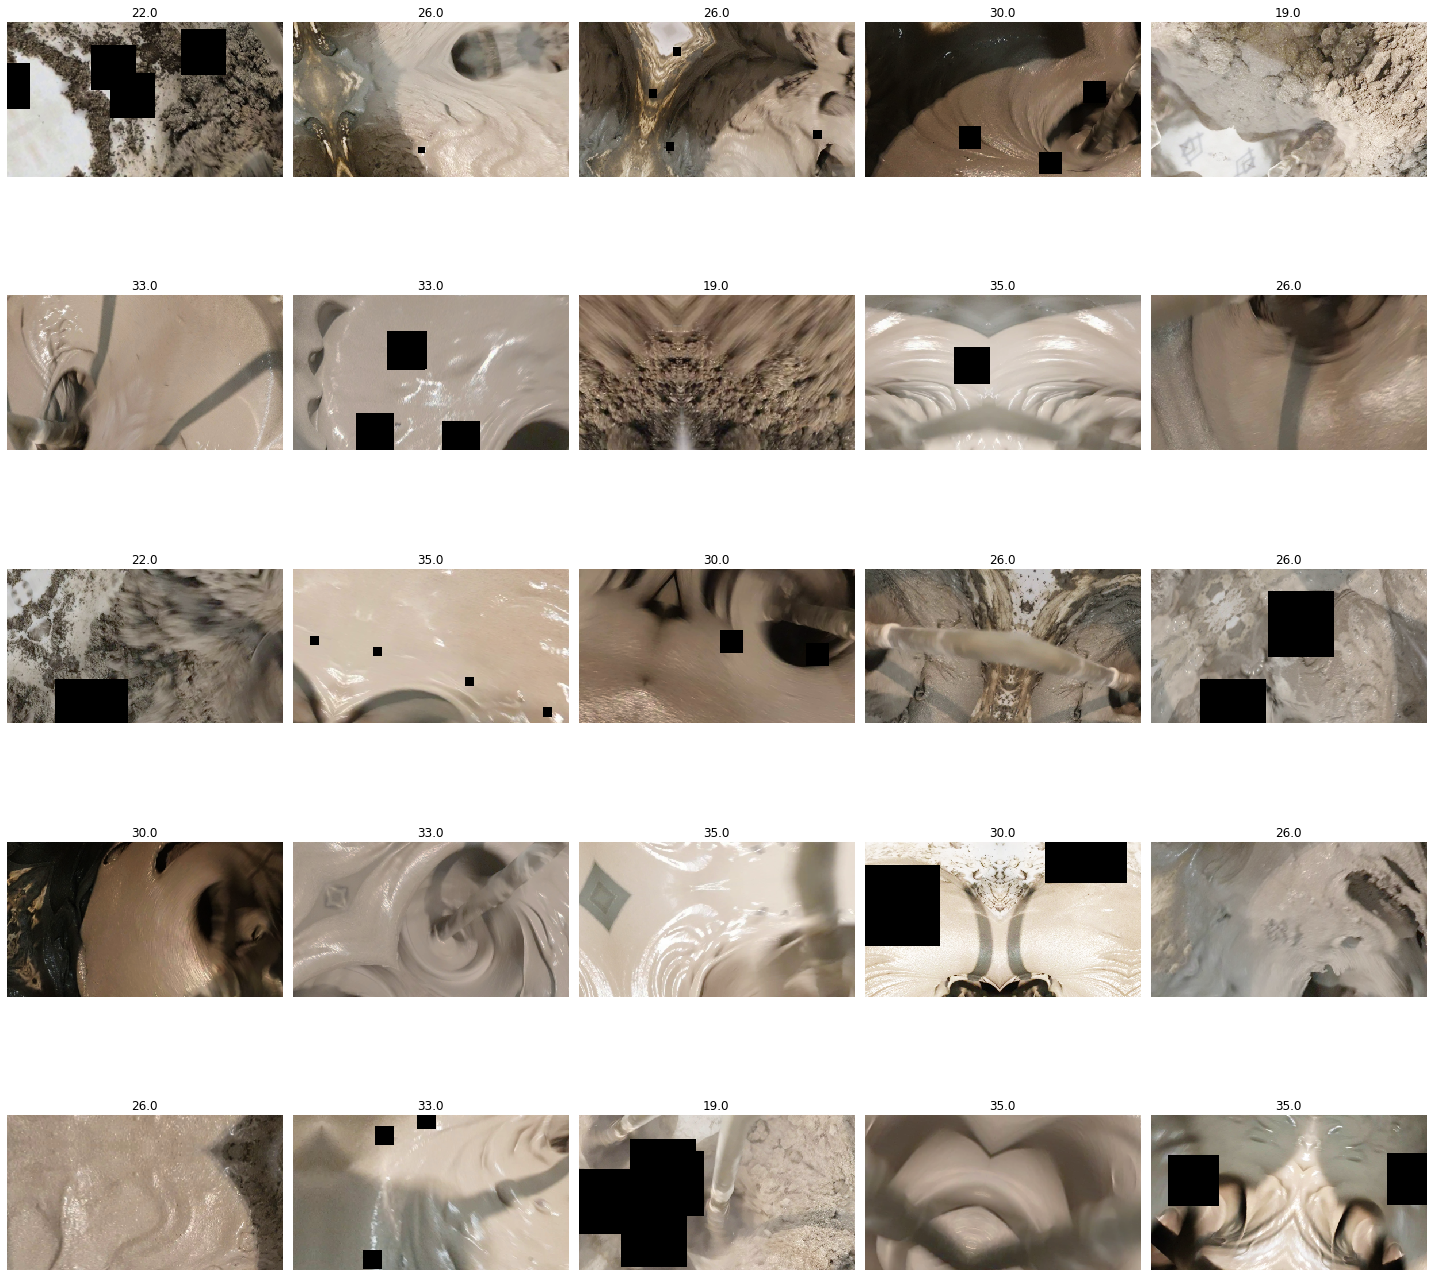

In [6]:
# Look at the data
data.show_batch()

# Training

In [7]:
# regression = nn.Sequential(Flatten(), nn.Linear(2048,1), )
# learn = cnn_learner(data, models.resnet34, custom_head=regression)
# learn.summary()

In [8]:
def accuracy(input, target):
    return ((input - target).abs() <= 0.5).float() + \
        (2.5 > (input - target).abs() > 0.5).float() * (1.25 - (input - target).abs() / 2)

In [9]:
continuous_head = nn.Sequential(Flatten(), nn.Linear(69120,1), SigmoidRange(min_predict, max_predict))
learn = cnn_learner(data, models.resnet34, custom_head=continuous_head, loss_func=nn.L1Loss(), metrics=[accuracy])#.to_fp16()
learn.model_dir = model_folder

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time


/home/jakub/anaconda3/envs/devel/lib/python3.7/site-packages/torch/nn/modules/loss.py:91: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [ ]:
# callbacks = [ReduceLROnPlateauCallback(learn), EarlyStoppingCallback(learn)]
learn.fit_one_cycle(8, 4.2*1e-5)
# learn.fit_one_cycle(1, callbacks=callbacks, )

In [ ]:
learn.save(model_folder / ('silicon-frozen-' + str(major_version) + '.' + str(minor_version)))

### Hand evaluation

In [ ]:
learn.show_results(rows=5, figsize=(20, 20))

In [ ]:
from IPython import display

def evaluate_model(model):
    interp = ClassificationInterpretation.from_learner(model)

    losses,idxs = interp.top_losses()

    print(len(data.valid_ds)==len(losses)==len(idxs))
    
#     display(interp.plot_confusion_matrix(figsize=(12,12), dpi=60, return_fig=True))
#     interp.plot_confusion_matrix(figsize=(12,12), dpi=60, return_fig=True)
    
#     print(interp.most_confused(min_val=2))
    
    interp.plot_top_losses(9, figsize=(15,11), heatmap=False)
    interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

evaluate_model(learn)

## Unfreeze, train a bit more

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, slice(4.2e-7, 4.2e-5))

In [ ]:
evaluate_model(learn)

In [ ]:
learn.save(model_folder / ('silicon-unfrozen-' + str(major_version) + '.' + str(minor_version)))
learn.export(model_folder / ('silicon-' + str(major_version) + '.' + str(minor_version)))

In [ ]:
print(model_folder / ('silicon-unfrozen-' + str(major_version) + '.' + str(minor_version)))

In [ ]:
learn.export(model_folder / ('silicon-best'))  # 2.0%

# Prediction

In [ ]:
# model = learn.load('real-frozen-1.1')

# model.predict(Image.load())